<a href="https://colab.research.google.com/github/UCLM-ESI-NECULA/DataMining/blob/master/Statement1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -rf sample_data/

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn.cluster import KMeans
import spacy
from sklearn import metrics

DS1  = 'DS1-DatosConsumoAlimentario.txt'
DS2  = 'DS2-PreciosSemanales.txt'
DS3  = 'DS3-ProductData.txt'
DS4  = 'DS4-ComercioExterior.txt'
DS5  = 'DS5-CoronavirusCases.txt'
DS6  = 'DS6-owid-covid-data.csv'

Cleaned = 'Cleaned_'

DS1C = Cleaned + DS1
DS3C = Cleaned + DS3
DS6C = Cleaned + DS6
dir_path = '/content/drive/MyDrive/Scuola/UCLM/Colab Notebooks/Datasets/'
cleaned_path = '/content/drive/MyDrive/Scuola/UCLM/Colab Notebooks/Datasets/Datacard/Clean/'

#STATEMENT 1

In [ ]:
data = pd.read_csv(cleaned_path + DS3C, sep='|', decimal='.')

data['date'] = pd.to_datetime(data[['YEAR', 'MONTH']].assign(DAY=1))

# Grouping the data by 'familia', 'date' and calculating mean of price and sum of volume
grouped_data = data.groupby(['familia', 'date']).agg({'price_mean': 'mean', 'Volumen': 'sum'}).reset_index()

grouped_data

,familia,date,price_mean,Volumen
0,FRUTAS,2018-01-01,2.458676,112257234
1,FRUTAS,2018-02-01,2.530158,108098596
2,FRUTAS,2018-03-01,2.511014,115783152
3,FRUTAS,2018-04-01,2.610468,121524178
4,FRUTAS,2018-05-01,2.481722,143613605
...,...,...,...,...
99,OTROS,2020-07-01,2.150537,150425
100,OTROS,2020-08-01,2.500000,170745
101,OTROS,2020-09-01,2.500000,161401
102,OTROS,2020-10-01,2.000000,128503


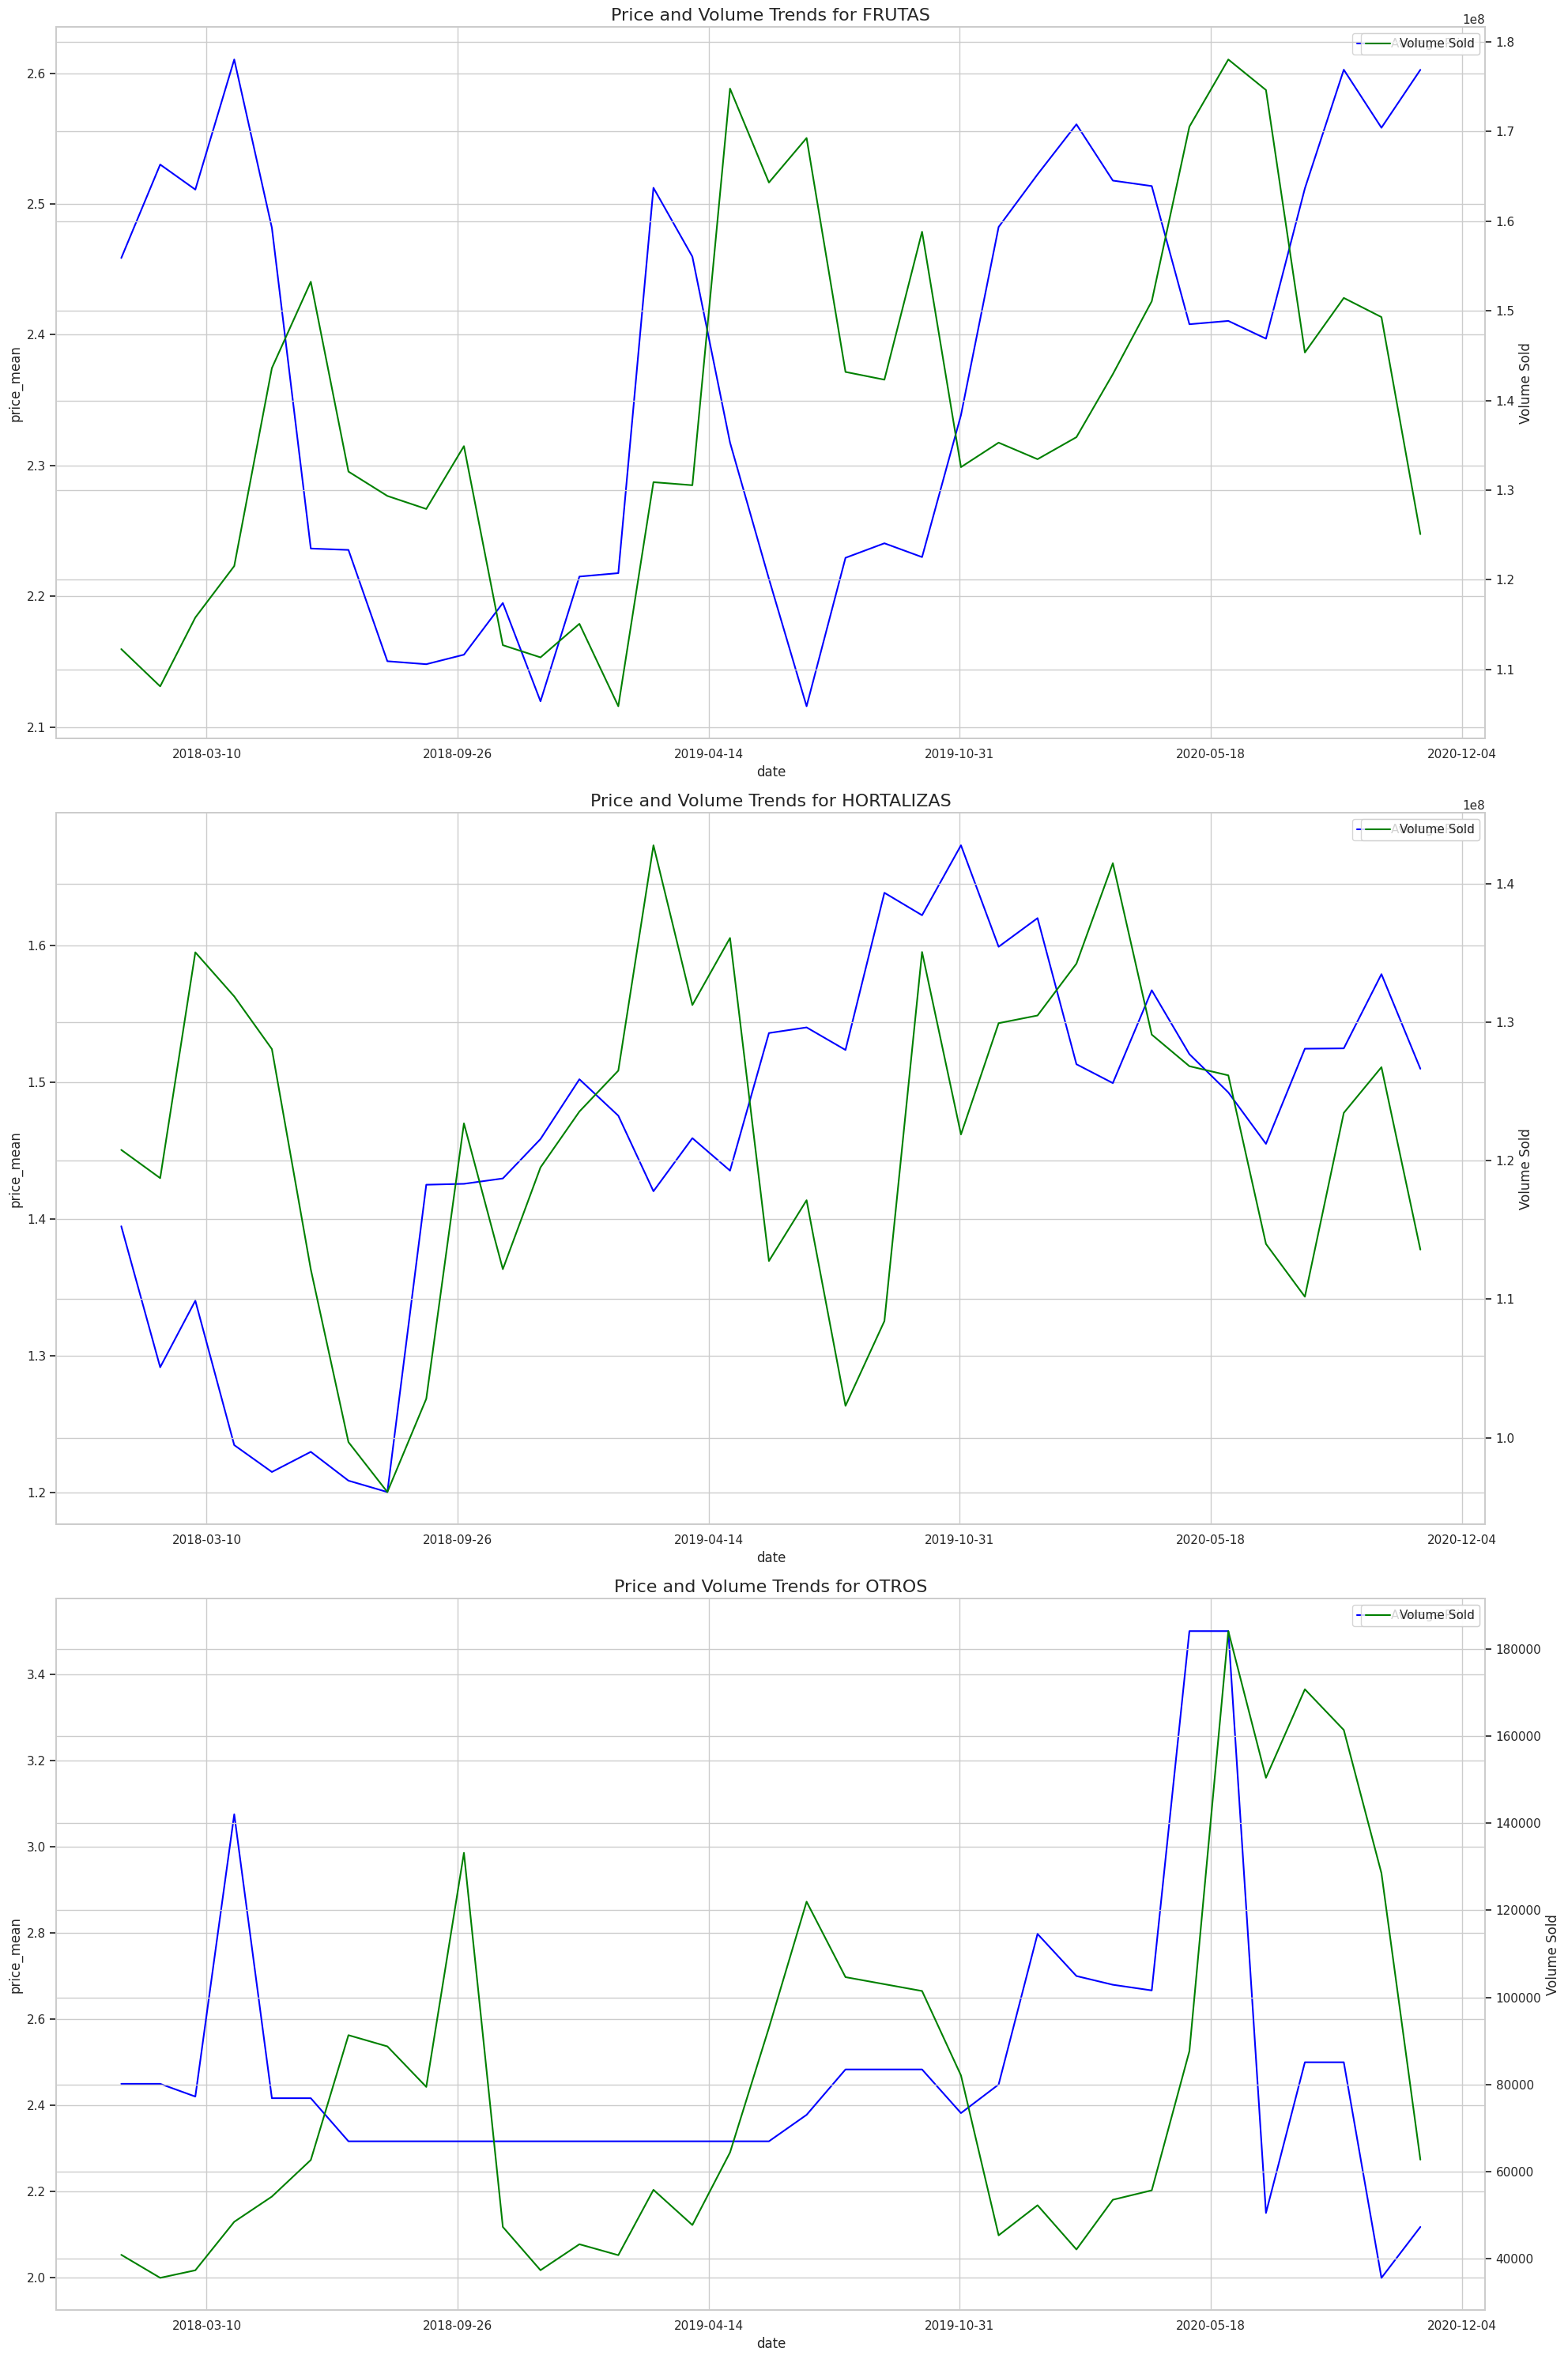

In [ ]:
families = grouped_data['familia'].unique()

# Setting up the plotting area
plt.figure(figsize=(20, 10 * len(families)))
sns.set(style="whitegrid")

# Looping through each family to create a subplot
for i, family in enumerate(families, 1):
    plt.subplot(len(families), 1, i)
    family_data = grouped_data[grouped_data['familia'] == family]

    # Plotting price and volume trends
    sns.lineplot(x='date', y='price_mean', data=family_data, label='Average Price', color='blue')
    ax2 = plt.gca().twinx()
    sns.lineplot(x='date', y='Volumen', data=family_data, label='Volume Sold', color='green', ax=ax2)

    # Setting plot titles and labels
    plt.title(f'Price and Volume Trends for {family}', fontsize=16)
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=6))  # Limiting the number of x-axis labels for readability
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    ax2.set_ylabel('Volume Sold')

    # Adding legends
    plt.gca().legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


**El coeficiente de correlación de Spearman es una medida de la correlación (la asociación o interdependencia) entre dos variables aleatorias (tanto continuas como discretas) basado en rangos**.

La **interpretación** de coeficiente de Spearman es **igual que la del coeficiente de correlación de Pearson**.

Suele funcionar mejor que Pearson cuando los datos contienen outliers ya que el cálculo se basa en el orden y no en el valor absoluto.


In [ ]:
# Calculating the correlation between price and volume for each family
family_correlations = {}
for family in families:
    family_data = grouped_data[grouped_data['familia'] == family]

    # Pearson correlation
    pearson_corr, pearson_pval = pearsonr(family_data['price_mean'], family_data['Volumen'])

    # Spearman correlation
    spearman_corr, spearman_pval = spearmanr(family_data['price_mean'], family_data['Volumen'])

    family_correlations[family] = {'Pearson Correlation': pearson_corr,
                                   'Pearson P-Value': pearson_pval,
                                   'Spearman Correlation': spearman_corr,
                                   'Spearman P-Value': spearman_pval}

# Converting the correlations dictionary to a DataFrame
family_correlations_df = pd.DataFrame.from_dict(family_correlations, orient='index')
family_correlations_df.sort_values(by='Pearson Correlation', ascending=False, inplace=True)

family_correlations_df


,Pearson Correlation,Pearson P-Value,Spearman Correlation,Spearman P-Value
HORTALIZAS,0.229861,0.184059,0.127731,0.464641
OTROS,0.128984,0.467217,-0.040639,0.819496
FRUTAS,-0.016300,0.925954,0.029692,0.865547


Non of the families have a direct correlation, lets see the products

In [ ]:
n_product = len(data['product'].unique())
n_product

167

In [ ]:
#Pearson
# Calculating the correlation for each product
pearson_results = []

print(data['price_mean'].nunique() == 1 and data['Volumen'].nunique() == 1)

for product, grouped_data in data.groupby('product'):
    if len(grouped_data) > 1:
        pearson = pearsonr(grouped_data['price_mean'], grouped_data['Volumen'])
        if pd.notna(pearson) and pearson[1] <= 0.05: #Min p-value for not null hypotesys
            pearson_results.append({'Product': product, 'Pearson Corr': pearson[0], 'Pearson p-val': pearson[1]})

discarded = n_product - len(pearson_results)
print(f'Discarded {discarded} from the total of {n_product} products, because the p-val was not enough')

# Converting the results to a DataFrame
pearson_df = pd.DataFrame(pearson_results)

pearson_df.sort_values(by='Pearson Corr', ascending=False, inplace=True)
pearson_df




False


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


Discarded 111 from the total of 167 products, because the p-val was not enough


,Product,Pearson Corr,Pearson p-val
3,CARAMBOLA,0.682482,8.744686e-06
0,AJOS SECO,0.623440,6.313645e-05
15,FRUTAS FRESA,0.577567,2.802123e-04
46,PEREJIL,0.564892,4.072117e-04
47,PITAHAYA,0.536438,8.941197e-04
42,PAPAYO,0.530401,1.047281e-03
17,FRUTAS HIGO CHUMBO,0.517872,2.398611e-03
38,NABO,0.497824,2.341884e-03
51,SETA,0.439613,8.232362e-03
23,HABA,0.439031,1.194288e-02


In [ ]:
#Spear
# Calculating the correlation for each product
spear_results = []

for product, grouped_data in data.groupby('product'):
    if len(grouped_data) > 1:
        pearson = pearsonr(grouped_data['price_mean'], grouped_data['Volumen'])
        spear = spearmanr(grouped_data['price_mean'], grouped_data['Volumen'])
        if pd.notna(spear) and spear.pvalue <= 0.05:
            spear_results.append({'Product': product,'Spear corr': spear.correlation, 'Spear p-val': spear.pvalue})

discarded = n_product - len(spear_results)
print(f'Discarded {discarded} from the total of {n_product} products, because the p-val was not enough')


# Converting the results to a DataFrame
spear_df = pd.DataFrame(spear_results)

spear_df.sort_values(by='Spear corr', ascending=False, inplace=True)
spear_df


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


Discarded 109 from the total of 167 products, because the p-val was not enough


,Product,Spear corr,Spear p-val
6,CARAMBOLA,0.587099,2.622797e-04
11,COLES LOMBARDA,0.584029,2.302195e-04
54,SETA,0.568908,3.623295e-04
0,AJOS SECO,0.541889,7.731989e-04
47,PEREJIL,0.524060,1.232625e-03
40,PAPAYO,0.463392,5.055149e-03
13,ESPINACA,0.459944,5.437078e-03
35,NABO,0.459588,5.477864e-03
5,CALABACÍN,0.449580,6.738145e-03
48,PITAHAYA,0.444927,7.403941e-03


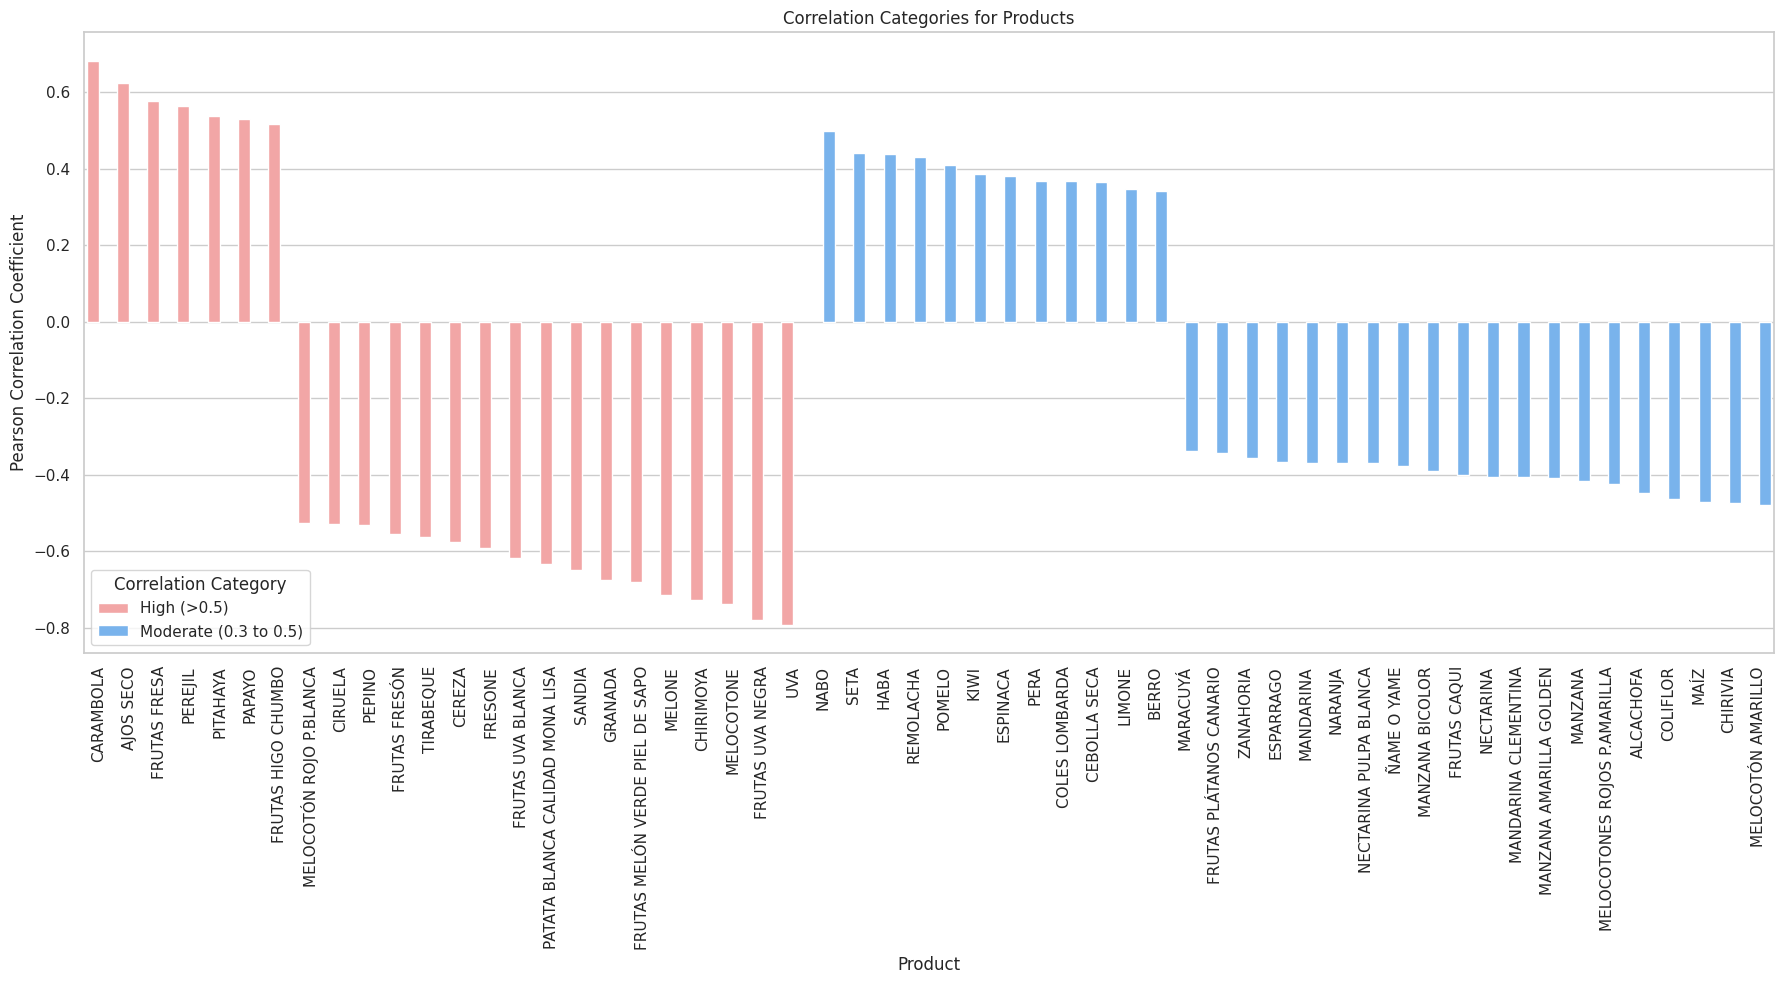

In [ ]:
# Categorizing the correlations
# Creating new DataFrames with an additional 'Correlation Category' column
high_corr = pearson_df[np.abs(pearson_df['Pearson Corr']) > 0.5].copy()
high_corr['Correlation Category'] = 'High (>0.5)'

moderate_corr = pearson_df[(np.abs(pearson_df['Pearson Corr']) <= 0.5) & (np.abs(pearson_df['Pearson Corr']) > 0.3)].copy()
moderate_corr['Correlation Category'] = 'Moderate (0.3 to 0.5)'

low_corr = pearson_df[np.abs(pearson_df['Pearson Corr']) <= 0.3].copy()
low_corr['Correlation Category'] = 'Low (<=0.3)'

# Combining the dataframes
combined_df = pd.concat([high_corr, moderate_corr, low_corr])

# Creating the combined plot
plt.figure(figsize=(18, 10))
sns.barplot(x='Product', y='Pearson Corr', hue='Correlation Category', data=combined_df, palette=["#ff9999","#66b3ff","#99ff99"])
plt.title('Correlation Categories for Products')
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend(title='Correlation Category')
plt.tight_layout()
plt.show()

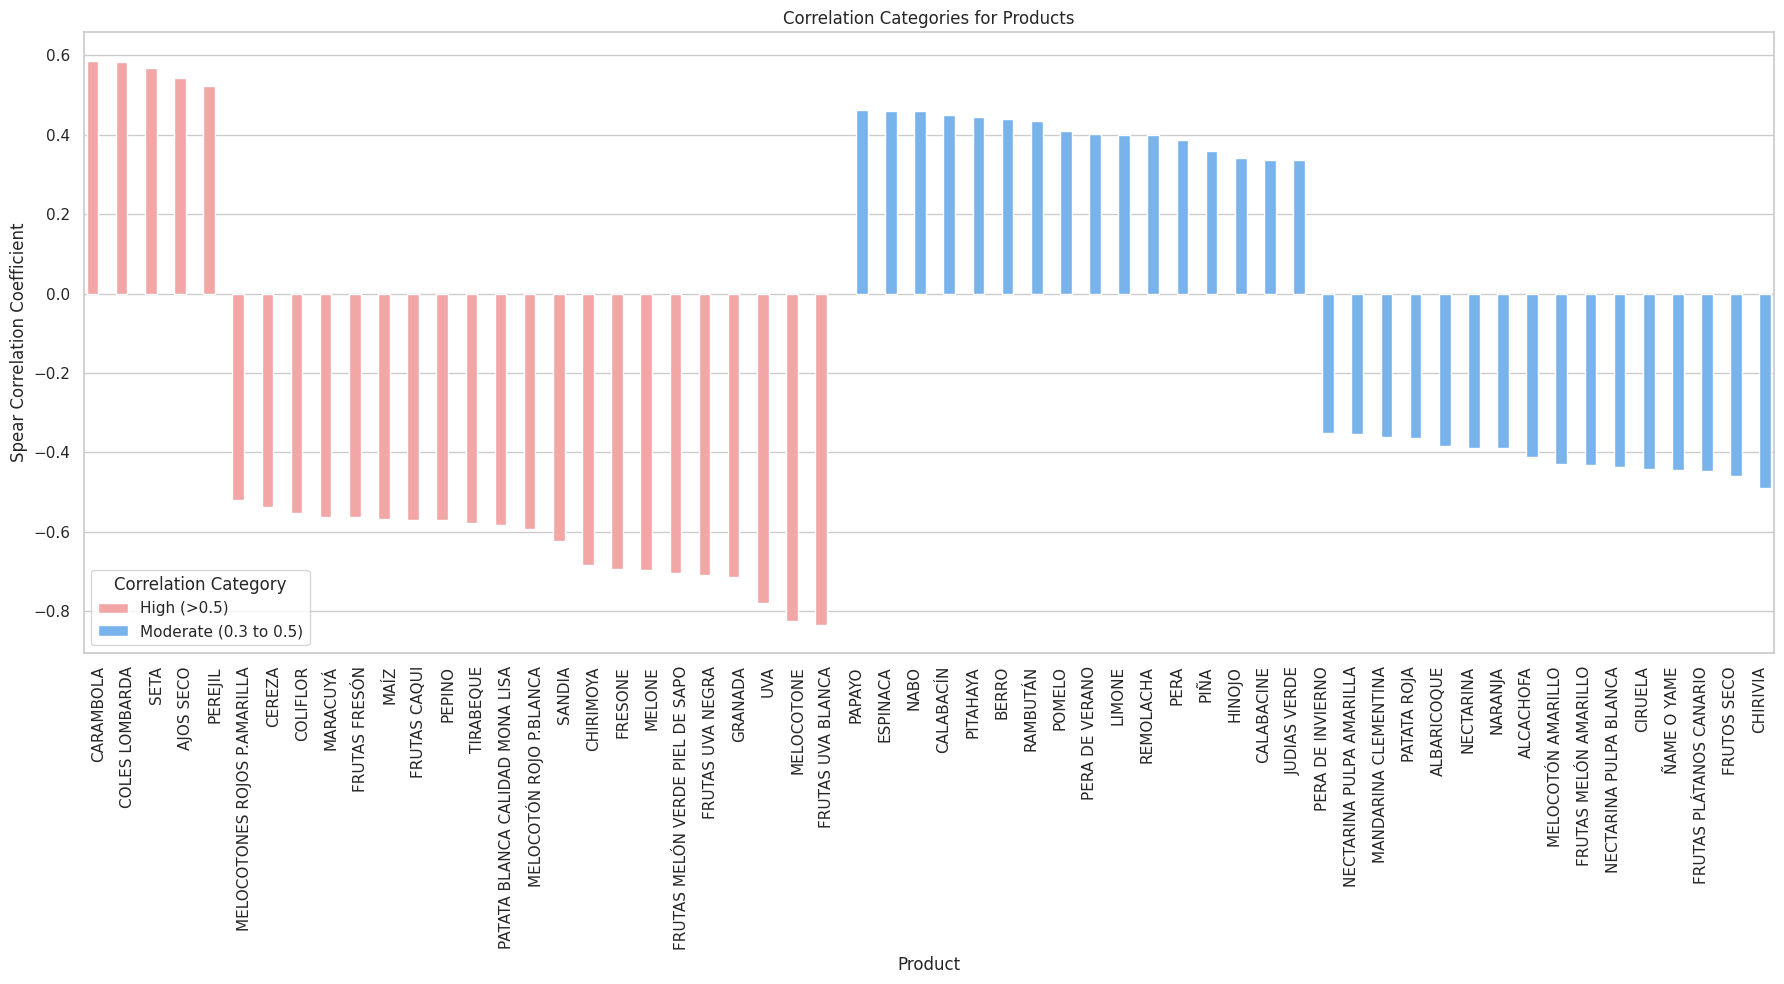

In [ ]:
# Categorizing the correlations
# Creating new DataFrames with an additional 'Correlation Category' column
high_corr = spear_df[np.abs(spear_df['Spear corr']) > 0.5].copy()
high_corr['Correlation Category'] = 'High (>0.5)'

moderate_corr = spear_df[(np.abs(spear_df['Spear corr']) <= 0.5) & (np.abs(spear_df['Spear corr']) > 0.3)].copy()
moderate_corr['Correlation Category'] = 'Moderate (0.3 to 0.5)'

low_corr = spear_df[np.abs(spear_df['Spear corr']) <= 0.3].copy()
low_corr['Correlation Category'] = 'Low (<=0.3)'

# Combining the dataframes
combined_df = pd.concat([high_corr, moderate_corr, low_corr])

# Creating the combined plot
plt.figure(figsize=(18, 10))
sns.barplot(x='Product', y='Spear corr', hue='Correlation Category', data=combined_df, palette=["#ff9999","#66b3ff","#99ff99"])
plt.title('Correlation Categories for Products')
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.ylabel('Spear Correlation Coefficient')
plt.legend(title='Correlation Category')
plt.tight_layout()
plt.show()

#STATEMENT 2

In [ ]:
# Reading the COVID data
covid_data = pd.read_csv(cleaned_path + DS6C, sep='|')

# Reading the food consumption data
consumption_data = pd.read_csv(cleaned_path + DS1C, sep='|')

In [ ]:
# Filtering the data for the months March to November (3 to 11) for the years 2018, 2019, and 2020
filtered_data = consumption_data[(consumption_data['MONTH'] >= 3) & (consumption_data['MONTH'] <= 11) &
                          (consumption_data['YEAR'].isin([2018, 2019, 2020]))]

# Calculating the median volume for each product for the years 2018 and 2019
median_volumes = filtered_data[filtered_data['YEAR'] != 2020].groupby(['product']).median()['Volumen']

# Preparing the 2020 data for comparison
data_2020 = filtered_data[filtered_data['YEAR'] == 2020].groupby(['product']).sum()['Volumen']

# Combining the median data and 2020 data for comparison
combined_data = pd.DataFrame({'Median_Volume_2018_2019': median_volumes, 'Total_Volume_2020': data_2020}).reset_index()

combined_data.head()

,product,Median_Volume_2018_2019,Total_Volume_2020
0,AGUACATE,4928.485,27893.67
1,AJOS,2772.470,13723.17
2,ALBARICOQUES,709.600,38154.50
3,ALCACHOFAS,1956.305,31911.02
4,APIO,1778.800,8025.33


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initializing the scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Selecting the columns to scale
data_to_scale = combined_data[['Median_Volume_2018_2019', 'Total_Volume_2020']]

# Applying StandardScaler
standard_scaled_data = standard_scaler.fit_transform(data_to_scale)

# Applying MinMaxScaler
minmax_scaled_data = minmax_scaler.fit_transform(data_to_scale)

# Creating dataframes for the scaled data for easier comparison
standard_scaled_df = pd.DataFrame(standard_scaled_data, columns=['Standard_Scaled_Median_2018_2019', 'Standard_Scaled_Total_2020'], index=combined_data['product'])
minmax_scaled_df = pd.DataFrame(minmax_scaled_data, columns=['MinMax_Scaled_Median_2018_2019', 'MinMax_Scaled_Total_2020'], index=combined_data['product'])

standard_scaled_df.head(), minmax_scaled_df.head()

(              Standard_Scaled_Median_2018_2019  Standard_Scaled_Total_2020
 product                                                                   
 AGUACATE                             -0.379866                   -0.379029
 AJOS                                 -0.416304                   -0.402991
 ALBARICOQUES                         -0.451168                   -0.361679
 ALCACHOFAS                           -0.430098                   -0.372236
 APIO                                 -0.433098                   -0.412625,
               MinMax_Scaled_Median_2018_2019  MinMax_Scaled_Total_2020
 product                                                               
 AGUACATE                            0.013664                  0.007686
 AJOS                                0.007686                  0.003779
 ALBARICOQUES                        0.001966                  0.010515
 ALCACHOFAS                          0.005423                  0.008794
 APIO                              

In [ ]:
# Using the already prepared combined data (median for 2018 & 2019 and total for 2020)
# Applying StandardScaler
scaled_data_for_clustering = standard_scaler.fit_transform(combined_data[['Median_Volume_2018_2019', 'Total_Volume_2020']])


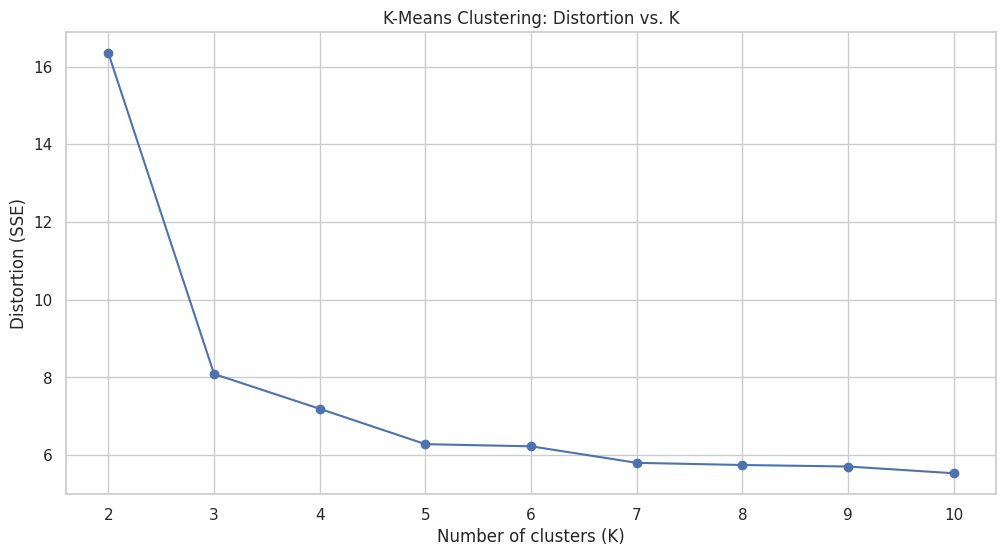

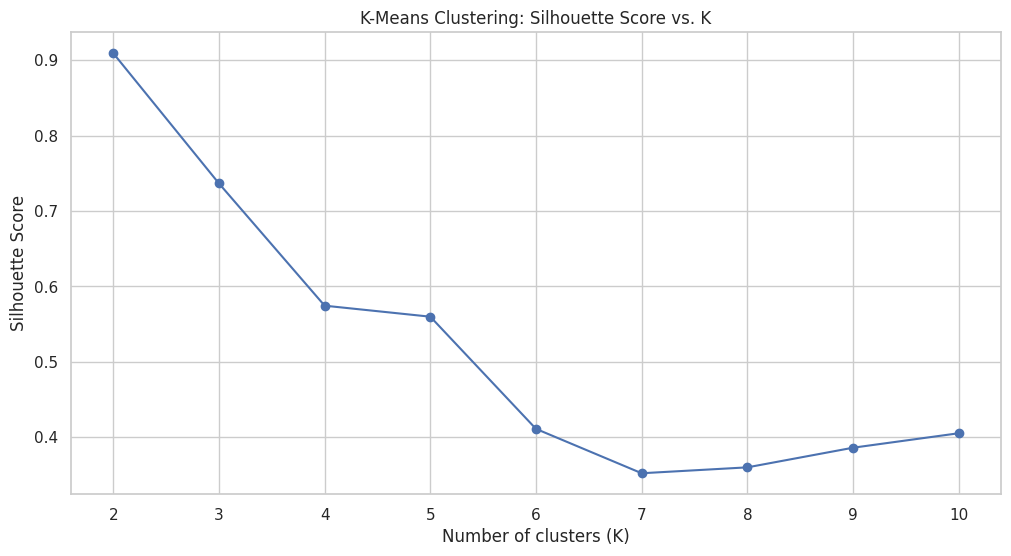

In [ ]:
# Defining the specified parameters for K-means clustering
iterations = 10  # to run 10 times with different random centroids
max_iter = 300   # maximum number of iterations for each single run
tol = 1e-04      # tolerance with regard to changes in within-cluster sum-squared-error
random_state = 0 # random seed

# Re-running the clustering with the updated parameters
distortions = []
silhouettes = []

for i in range(2, 11):
    km = KMeans(n_clusters=i, init='random', n_init=iterations, max_iter=max_iter, tol=tol, random_state=random_state)
    labels = km.fit_predict(scaled_data_for_clustering)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(scaled_data_for_clustering, labels))

# Plotting Distortion (SSE) for each K
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion (SSE)')
plt.title('K-Means Clustering: Distortion vs. K')
plt.show()

# Plotting Silhouette Score for each K
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), silhouettes, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('K-Means Clustering: Silhouette Score vs. K')
plt.show()

In [ ]:
# Running KMeans with the chosen number of clusters: 5
kmeans = KMeans(n_clusters=5, init='random', n_init=iterations, max_iter=max_iter, tol=tol, random_state=random_state)
clusters = kmeans.fit_predict(scaled_data_for_clustering)

# Adding the cluster labels to the combined data
combined_data['Cluster'] = clusters
# Analyzing the cluster centroids
centroids = kmeans.cluster_centers_

# Creating a DataFrame for centroids for easier interpretation
centroids_df = pd.DataFrame(centroids, columns=['Median_Volume_2018_2019', 'Total_Volume_2020'])
centroids_df['Cluster'] = range(5)

cluster_counts = combined_data['Cluster'].value_counts().sort_index()
centroids_df, cluster_counts

(   Median_Volume_2018_2019  Total_Volume_2020  Cluster
 0                -0.187954          -0.221231        0
 1                 0.778342           0.626649        1
 2                 4.493911           4.577306        2
 3                 0.161436           0.175191        3
 4                -0.400532          -0.372503        4,
 0    12
 1     4
 2     2
 3     6
 4    27
 Name: Cluster, dtype: int64)

In [ ]:
# We will use the standard deviation of the change between the 2018-2019 median and 2020 total volumes to define significant changes.
change_std = np.std(centroids_df['Total_Volume_2020'] - centroids_df['Median_Volume_2018_2019'])

# A significant change as a change greater than one standard deviation from the mean change.

# Assigning new impact categories based on the significant threshold.
for index, row in centroids_df.iterrows():
    median_2018_2019 = row['Median_Volume_2018_2019']
    total_2020 = row['Total_Volume_2020']
    change = total_2020 - median_2018_2019

    if change > change_std:
        impact = "Significant Positive Impact"
    elif change > 0:
        impact = "Slight Positive Impact"
    elif change < -change_std:
        impact = "Significant Negative Impact"
    elif change < 0:
        impact = "Slight Negative Impact"
    else:
        impact = "Neutral Impact"

    centroids_df.loc[index, 'Impact'] = impact

# Now we will extract the list of products for each refined impact category.
cluster_impact_mapping = centroids_df.set_index('Cluster')['Impact'].to_dict()
combined_data['Impact_Cluster'] = combined_data['Cluster'].map(cluster_impact_mapping)

# Extracting product lists for each refined impact cluster.
cluster_product_lists = {}
for cluster, impact in cluster_impact_mapping.items():
    products_in_cluster = combined_data[combined_data['Cluster'] == cluster]['product'].tolist()
    cluster_product_lists[impact] = products_in_cluster

# Showing the refined impact for each cluster
centroids_df[['Cluster', 'Impact']], cluster_product_lists

(   Cluster                       Impact
 0        0       Slight Negative Impact
 1        1  Significant Negative Impact
 2        2  Significant Positive Impact
 3        3       Slight Positive Impact
 4        4       Slight Positive Impact,
 {'Slight Negative Impact': ['CALABACINES',
   'FRUTAS IV GAMA',
   'KIWI',
   'LECHUGAS',
   'LIMONES',
   'MANDARINAS',
   'MELOCOTONES',
   'OTRAS FRUTAS FRESCAS',
   'PERAS',
   'PIMIENTOS',
   'VERD./HORT. IV GAMA',
   'ZANAHORIAS'],
  'Significant Negative Impact': ['NARANJAS',
   'PATATAS FRESCAS',
   'TOMATES',
   'TOTAL PATATAS'],
  'Significant Positive Impact': ['T.FRUTAS FRESCAS', 'T.HORTALIZAS FRESCAS'],
  'Slight Positive Impact': ['AGUACATE',
   'AJOS',
   'ALBARICOQUES',
   'ALCACHOFAS',
   'APIO',
   'BERENJENAS',
   'BROCOLI',
   'CEREZAS',
   'CHAMPIÑONES',
   'CHIRIMOYAS',
   'CIRUELAS',
   'COLES',
   'COLIFLOR',
   'ESPARRAGOS',
   'FRESONES',
   'JUDIAS VERDES',
   'MANGOS',
   'NECTARINAS',
   'PATATAS CONGELADAS',
   '

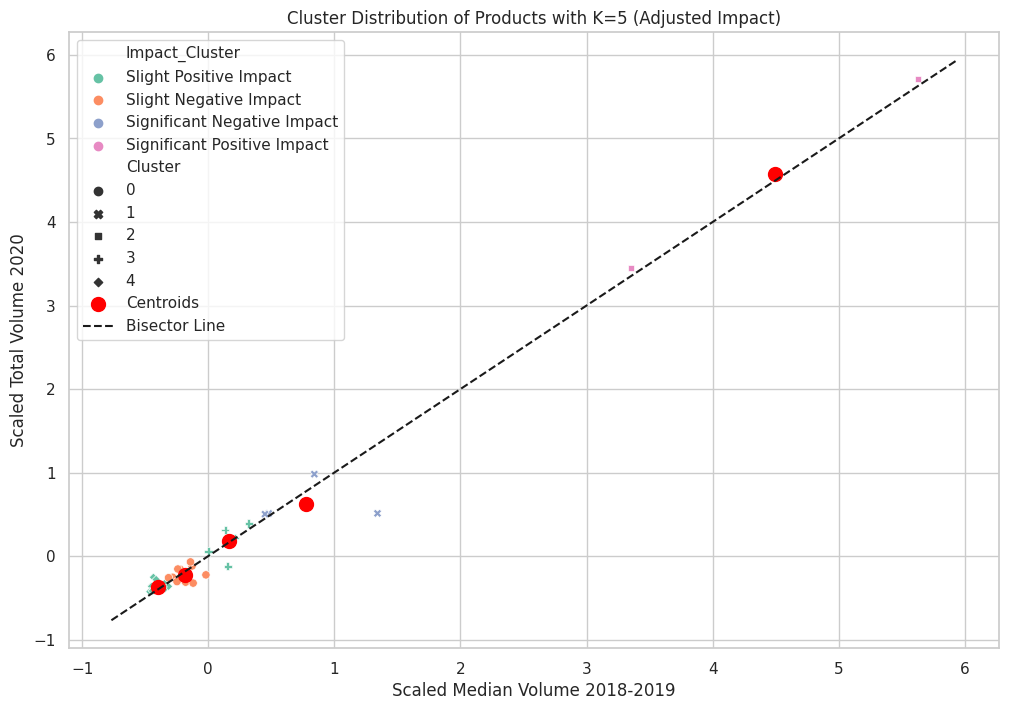

In [ ]:

# Now, let's re-generate the graph with the proper naming and include the bisector line.
plt.figure(figsize=(12, 8))
sns.scatterplot(x=scaled_data_for_clustering[:, 0], y=scaled_data_for_clustering[:, 1], hue=combined_data['Impact_Cluster'], palette='Set2', style=combined_data['Cluster'])
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', label='Centroids')

# Adding bisector line (where the median volume equals total volume)
x_values = np.array(plt.xlim())
y_values = x_values  # Bisector line
plt.plot(x_values, y_values, color="k", linestyle="--", label='Bisector Line')


plt.title('Cluster Distribution of Products with K=5 (Adjusted Impact)')
plt.xlabel('Scaled Median Volume 2018-2019')
plt.ylabel('Scaled Total Volume 2020')
plt.legend()
plt.show()

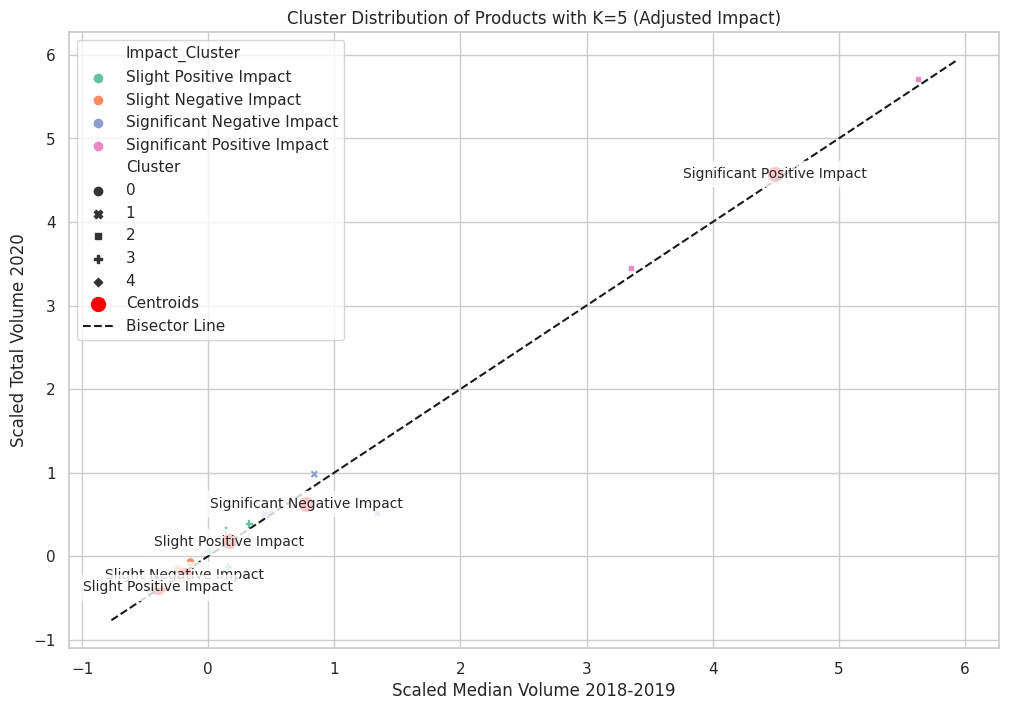

In [ ]:

# Updating the combined data with new impact categories
combined_data['Impact'] = combined_data['Cluster'].map(centroids_df.set_index('Cluster')['Impact'].to_dict())


# Now, let's re-generate the graph with the proper naming and include the bisector line.
plt.figure(figsize=(12, 8))
sns.scatterplot(x=scaled_data_for_clustering[:, 0], y=scaled_data_for_clustering[:, 1], hue=combined_data['Impact_Cluster'], palette='Set2', style=combined_data['Cluster'])
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', label='Centroids')

# Adding bisector line (where the median volume equals total volume)
x_values = np.array(plt.xlim())
y_values = x_values  # Bisector line
plt.plot(x_values, y_values, color="k", linestyle="--", label='Bisector Line')


# Adding labels for centroids based on the new impacts
for i, centroid in enumerate(centroids):
    plt.text(centroid[0], centroid[1], centroids_df.loc[i, 'Impact'], fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

plt.title('Cluster Distribution of Products with K=5 (Adjusted Impact)')
plt.xlabel('Scaled Median Volume 2018-2019')
plt.ylabel('Scaled Total Volume 2020')
plt.legend()
plt.show()